In [1]:
import sys
import os
import pandas as pd
from pathlib import Path
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sb
import contextlib
import cobra as cb


from matplotlib.colors import ListedColormap

from itertools import combinations as com

current = os.path.dirname(os.path.abspath(''))
parent = os.path.dirname(current)
metcon = os.path.dirname(parent)
sys.path.append(metcon)

import metconsin
# from metconsin import metconsin_sim,save_metconsin,metconsin_environment
from metconsin import analysis_helpers as ah

## Data Required

This example requires the supplemental material from:

    Weiss AS, Burrichter AG, Durai Raj AC, von Strempel A, Meng C, Kleigrewe K,
    et al. In vitro interaction network of a synthetic gut bacterial community. The
    ISME journal. 2022;16(4):1095–1109.



## Preparing the simulations

We need to start by finding the models and creating a .csv file with paths to them for MetConSIN to read. It needs to be a .csv with a column headed "Species" and a column headed "File" (note these can be changed as long as MetConSIN is passed the new column headers in the appropriate keyword arguments, see the docs).

In [2]:
xml_files = [fl for fl in os.listdir('OMM12_20210804_gapseq_full_models') if '.xml' in fl]

In [3]:
xml_files

['Clostridium_innocuum_I46.xml',
 'Bacteroides_caecimuris_I48.xml',
 'Limosilactobacillus_reuteri_I49.xml',
 'Flavonifractor_plautii_YL31.xml',
 'Muribaculum_intestinale_YL27.xml',
 'Akkermansia_muciniphilaYL44.xml',
 'Turicimonas_muris_YL45.xml',
 'Acutalibacter_muris_KB1.xml',
 'Enterocloster_clostridioformis_YL32.xml',
 'Bifidobacterium_animalis_YL2.xml',
 'Enterococcus_faecalis_KB1.xml',
 'Blautia_coccoides_YL58.xml']

In [4]:
spc = [fl.replace(".xml","") for fl in xml_files]

In [5]:
file_info = pd.DataFrame(index = xml_files,columns = ["Species","Name","File"])
file_info["Species"] = spc
file_info["Name"] = spc
file_info["File"] = [os.path.join('OMM12_20210804_gapseq_full_models',fl) for fl in xml_files]

In [6]:
file_info

,Species,Name,File
Clostridium_innocuum_I46.xml,Clostridium_innocuum_I46,Clostridium_innocuum_I46,OMM12_20210804_gapseq_full_models/Clostridium_...
Bacteroides_caecimuris_I48.xml,Bacteroides_caecimuris_I48,Bacteroides_caecimuris_I48,OMM12_20210804_gapseq_full_models/Bacteroides_...
Limosilactobacillus_reuteri_I49.xml,Limosilactobacillus_reuteri_I49,Limosilactobacillus_reuteri_I49,OMM12_20210804_gapseq_full_models/Limosilactob...
Flavonifractor_plautii_YL31.xml,Flavonifractor_plautii_YL31,Flavonifractor_plautii_YL31,OMM12_20210804_gapseq_full_models/Flavonifract...
Muribaculum_intestinale_YL27.xml,Muribaculum_intestinale_YL27,Muribaculum_intestinale_YL27,OMM12_20210804_gapseq_full_models/Muribaculum_...
Akkermansia_muciniphilaYL44.xml,Akkermansia_muciniphilaYL44,Akkermansia_muciniphilaYL44,OMM12_20210804_gapseq_full_models/Akkermansia_...
Turicimonas_muris_YL45.xml,Turicimonas_muris_YL45,Turicimonas_muris_YL45,OMM12_20210804_gapseq_full_models/Turicimonas_...
Acutalibacter_muris_KB1.xml,Acutalibacter_muris_KB1,Acutalibacter_muris_KB1,OMM12_20210804_gapseq_full_models/Acutalibacte...
Enterocloster_clostridioformis_YL32.xml,Enterocloster_clostridioformis_YL32,Enterocloster_clostridioformis_YL32,OMM12_20210804_gapseq_full_models/Enterocloste...
Bifidobacterium_animalis_YL2.xml,Bifidobacterium_animalis_YL2,Bifidobacterium_animalis_YL2,OMM12_20210804_gapseq_full_models/Bifidobacter...


Save it to .csv so that MetConSIN can read it.

In [7]:
model_info_flnm = "weiss_model_info.csv"
file_info.to_csv(model_info_flnm)

The next thing we need to prepare is the medium. In this example, Weiss et al. provide medium as a .csv file. There is no real need to load it directly, but we do so to check that it is formatted correctly.

In [8]:
weiss_medium_fl = "weiss_medium.csv"
medium = pd.read_csv(weiss_medium_fl,sep = ',',index_col =0 )

Importantly, the .csv has columns corresponding to the metabolites used (in this case using the ModelSEED notation, which matches the genome scale models we are using) and a flux value. The name is useful for double checking the medium, but will not be used. Instead, MetConSIN uses the names given by the models (which will often, and in this case, include compartment tags --- e.g. -e0). 

In [9]:
medium

,metabolite,fullName,fluxValue
0,cpd00001,H2O,55500.000000
1,cpd00007,O2,0.000000
2,cpd00067,H+,100.000000
3,cpd00027,D-Glucose,9.865273
4,cpd00076,Sucrose,0.219106
...,...,...,...
98,cpd00122,N-acetyl-D-gluosamine,0.009310
99,cpd00232,N-acetylneuraminate (as sialic residue),0.051237
100,cpd00832,N-acetyl-D-galactosamine,0.003296
101,cpd00108,galactose,0.159797


The metconsin_environment function will create a dictionary to defined the environment using the flux values given in the medium and metabolite names from the models. Note that currently there must be a column in the media_source .csv labeled "fluxValue", but the metabolite id column (in this case "metabolite") can be set with the "metabolite_id_type" parameter in metconsin_environment (if a media source is being used, as here). This function loads the models to get the names that they use for the metabolites.

In [10]:
env = metconsin.metconsin_environment(spc,model_info_flnm,media_source = weiss_medium_fl,metabolite_id_type="metabolite")

Set parameter TokenServer to value "infrateam.lanl.gov"
[metconsin_environment] Creating environment from file weiss_medium.csv


Finally, we set up a few final parameters. Here, we will save to a folder called "weiss_results", start with 0.1 biomass for each community member, flow oxygen in, and run the simulation for 1 time unit.

In [11]:
save_flder = 'weiss_results_tmp'
Path(save_flder).mkdir(parents=True, exist_ok=True)

In [12]:
initial_abundance = dict([(sp,0.1) for sp in spc])
oxygen_in = {"O2-e0":100}

In [13]:
et = 20

## Run the simulation with the full community

In [14]:
with open("full_community.log",'w') as fl:
    full_community = metconsin.metconsin_sim(spc,model_info_flnm,media = env,initial_abundance = initial_abundance,metabolite_inflow = oxygen_in,endtime = et,flobj=fl)

[MetConSIN] Loaded 12 models successfully
[MetConSIN] Clostridium_innocuum_I46 COBRA initial growth rate: 0.31314407570673186

[MetConSIN] Bacteroides_caecimuris_I48 COBRA initial growth rate: 0.31314407570672964

[MetConSIN] Limosilactobacillus_reuteri_I49 COBRA initial growth rate: 0.23925614773098092

[MetConSIN] Flavonifractor_plautii_YL31 COBRA initial growth rate: 0.07170892407294675

[MetConSIN] Muribaculum_intestinale_YL27 COBRA initial growth rate: 0.3131440757067473

[MetConSIN] Akkermansia_muciniphilaYL44 COBRA initial growth rate: 0.07170892407294675

[MetConSIN] Turicimonas_muris_YL45 COBRA initial growth rate: 0.07170892407294675

[MetConSIN] Acutalibacter_muris_KB1 COBRA initial growth rate: 0.09025202909273898

[MetConSIN] Enterocloster_clostridioformis_YL32 COBRA initial growth rate: 0.31314407570672964

[MetConSIN] Bifidobacterium_animalis_YL2 COBRA initial growth rate: 0.05478884086472339

[MetConSIN] Enterococcus_faecalis_KB1 COBRA initial growth rate: 0.05478884086

Muribaculum_intestinale_YL27  [fba_gb] optimizing LP
Muribaculum_intestinale_YL27  [fba_gb] optimizing with  5162  constraints
Muribaculum_intestinale_YL27  [fba_gb] LP Status:  OPTIMAL
Muribaculum_intestinale_YL27 [fba_gb] Initial Growth Rate: 0.31314407570894304
Muribaculum_intestinale_YL27 [fba_gb] Secondary Objective Value = 130.81074998828143
Muribaculum_intestinale_YL27 [fba_gb] Distance from all_vars: 2.9610774057509077e-09
Muribaculum_intestinale_YL27 [fba_gb] Start basis growth rate: 0.31314407570891944
 Start basis total flux: 130.8107499868952
Muribaculum_intestinale_YL27 [fba_gb] Removed variable 2951 = 2.1569144040278765e-12.
 Value of lambda: 2.732574887406911e-10 
 Value of Abar: 0.00789334050447448
Muribaculum_intestinale_YL27 [fba_gb] Distance from all_vars: 1.1788640279831327e-05
Muribaculum_intestinale_YL27 [fba_gb] New growth rate: 0.31314397475580336
 New total flux: 130.81070765678237
Muribaculum_intestinale_YL27  [fba_gb] Done in  0  minutes,  46.1266930103302  s

Blautia_coccoides_YL58  [fba_gb] initializing LP
Blautia_coccoides_YL58  [fba_gb] Adding constraints
Blautia_coccoides_YL58  [fba_gb] optimizing LP
Blautia_coccoides_YL58  [fba_gb] optimizing with  6198  constraints
Blautia_coccoides_YL58  [fba_gb] LP Status:  OPTIMAL
Blautia_coccoides_YL58 [fba_gb] Initial Growth Rate: 0.2392561477314356
Blautia_coccoides_YL58 [fba_gb] Secondary Objective Value = 87.53114224663787
Blautia_coccoides_YL58 [fba_gb] Distance from all_vars: 7.80176391400096e-07
Blautia_coccoides_YL58 [fba_gb] Start basis growth rate: 0.23925614773145298
 Start basis total flux: 87.53114186136203
Blautia_coccoides_YL58 [fba_gb] Removed variable 3593 = 0.0.
 Value of lambda: 0.0 
 Value of Abar: 0.010330989775745847
Blautia_coccoides_YL58 [fba_gb] Distance from all_vars: 2.246915831276017e-07
Blautia_coccoides_YL58 [fba_gb] New growth rate: 0.2392561475024877
 New total flux: 87.53114227281826
Blautia_coccoides_YL58  [fba_gb] Done in  0  minutes,  56.007044076919556  seconds

surfin_fba: Finding New Basis at time  0.047355611883521366
surfin_fba: Solving IVP using Radau solver
surfin_fba: Finding New Basis at time  0.05016439520111053
surfin_fba: Solving IVP using Radau solver
surfin_fba: Finding New Basis at time  0.05088937699247623
surfin_fba: Solving IVP using Radau solver
surfin_fba: Finding New Basis at time  0.05387597734965299
surfin_fba: Solving IVP using Radau solver
surfin_fba: Finding New Basis at time  0.054280867354259695
surfin_fba: Solving IVP using Radau solver
surfin_fba: Finding New Basis at time  0.05435040348797731
surfin_fba: Solving IVP using Radau solver
surfin_fba: Finding New Basis at time  0.05435087983767401
surfin_fba: Solving IVP using Radau solver
surfin_fba: Finding New Basis at time  0.05567678519855578
surfin_fba: Solving IVP using Radau solver
surfin_fba: Finding New Basis at time  0.05577150224171158
surfin_fba: Solving IVP using Radau solver
surfin_fba: Finding New Basis at time  0.05579446924944418
surfin_fba: Solving I

[species_metabolite_network] Building network
[species_metabolite_network] Network built in  0  minutes,  33.23419904708862  seconds.
[heuristic_ss] Target: Clostridium_innocuum_I46
[heuristic_ss] Target: Bacteroides_caecimuris_I48
[heuristic_ss] Target: Limosilactobacillus_reuteri_I49
[heuristic_ss] Target: Flavonifractor_plautii_YL31
[heuristic_ss] Target: Muribaculum_intestinale_YL27
[heuristic_ss] Target: Akkermansia_muciniphilaYL44
[heuristic_ss] Target: Turicimonas_muris_YL45
[heuristic_ss] Target: Acutalibacter_muris_KB1
[heuristic_ss] Target: Enterocloster_clostridioformis_YL32
[heuristic_ss] Target: Bifidobacterium_animalis_YL2
[heuristic_ss] Target: Enterococcus_faecalis_KB1
[heuristic_ss] Target: Blautia_coccoides_YL58
[species_metabolite_network] Building network
[species_metabolite_network] Network built in  0  minutes,  32.76280188560486  seconds.
[heuristic_ss] Target: Clostridium_innocuum_I46
[heuristic_ss] Target: Bacteroides_caecimuris_I48
[heuristic_ss] Target: Limos

[heuristic_ss] Target: Clostridium_innocuum_I46
[heuristic_ss] Target: Bacteroides_caecimuris_I48
[heuristic_ss] Target: Limosilactobacillus_reuteri_I49
[heuristic_ss] Target: Flavonifractor_plautii_YL31
[heuristic_ss] Target: Muribaculum_intestinale_YL27
[heuristic_ss] Target: Akkermansia_muciniphilaYL44
[heuristic_ss] Target: Turicimonas_muris_YL45
[heuristic_ss] Target: Acutalibacter_muris_KB1
[heuristic_ss] Target: Enterocloster_clostridioformis_YL32
[heuristic_ss] Target: Bifidobacterium_animalis_YL2
[heuristic_ss] Target: Enterococcus_faecalis_KB1
[heuristic_ss] Target: Blautia_coccoides_YL58
[species_metabolite_network] Building network
[species_metabolite_network] Network built in  0  minutes,  33.614099979400635  seconds.
[heuristic_ss] Target: Clostridium_innocuum_I46
[heuristic_ss] Target: Bacteroides_caecimuris_I48
[heuristic_ss] Target: Limosilactobacillus_reuteri_I49
[heuristic_ss] Target: Flavonifractor_plautii_YL31
[heuristic_ss] Target: Muribaculum_intestinale_YL27
[he

[heuristic_ss] Target: Acutalibacter_muris_KB1
[heuristic_ss] Target: Enterocloster_clostridioformis_YL32
[heuristic_ss] Target: Bifidobacterium_animalis_YL2
[heuristic_ss] Target: Enterococcus_faecalis_KB1
[heuristic_ss] Target: Blautia_coccoides_YL58
[species_metabolite_network] Building network
[species_metabolite_network] Network built in  0  minutes,  32.461488008499146  seconds.
[heuristic_ss] Target: Clostridium_innocuum_I46
[heuristic_ss] Target: Bacteroides_caecimuris_I48
[heuristic_ss] Target: Limosilactobacillus_reuteri_I49
[heuristic_ss] Target: Flavonifractor_plautii_YL31
[heuristic_ss] Target: Muribaculum_intestinale_YL27
[heuristic_ss] Target: Akkermansia_muciniphilaYL44
[heuristic_ss] Target: Turicimonas_muris_YL45
[heuristic_ss] Target: Acutalibacter_muris_KB1
[heuristic_ss] Target: Enterocloster_clostridioformis_YL32
[heuristic_ss] Target: Bifidobacterium_animalis_YL2
[heuristic_ss] Target: Enterococcus_faecalis_KB1
[heuristic_ss] Target: Blautia_coccoides_YL58
[speci

[species_metabolite_network] Building network
[species_metabolite_network] Network built in  0  minutes,  32.72248315811157  seconds.
[heuristic_ss] Target: Clostridium_innocuum_I46
[heuristic_ss] Target: Bacteroides_caecimuris_I48
[heuristic_ss] Target: Limosilactobacillus_reuteri_I49
[heuristic_ss] Target: Flavonifractor_plautii_YL31
[heuristic_ss] Target: Muribaculum_intestinale_YL27
[heuristic_ss] Target: Akkermansia_muciniphilaYL44
[heuristic_ss] Target: Turicimonas_muris_YL45
[heuristic_ss] Target: Acutalibacter_muris_KB1
[heuristic_ss] Target: Enterocloster_clostridioformis_YL32
[heuristic_ss] Target: Bifidobacterium_animalis_YL2
[heuristic_ss] Target: Enterococcus_faecalis_KB1
[heuristic_ss] Target: Blautia_coccoides_YL58
[species_metabolite_network] Building network
[species_metabolite_network] Network built in  0  minutes,  33.4538779258728  seconds.
[heuristic_ss] Target: Clostridium_innocuum_I46
[heuristic_ss] Target: Bacteroides_caecimuris_I48
[heuristic_ss] Target: Limosi

[heuristic_ss] Target: Clostridium_innocuum_I46
[heuristic_ss] Target: Bacteroides_caecimuris_I48
[heuristic_ss] Target: Limosilactobacillus_reuteri_I49
[heuristic_ss] Target: Flavonifractor_plautii_YL31
[heuristic_ss] Target: Muribaculum_intestinale_YL27
[heuristic_ss] Target: Akkermansia_muciniphilaYL44
[heuristic_ss] Target: Turicimonas_muris_YL45
[heuristic_ss] Target: Acutalibacter_muris_KB1
[heuristic_ss] Target: Enterocloster_clostridioformis_YL32
[heuristic_ss] Target: Bifidobacterium_animalis_YL2
[heuristic_ss] Target: Enterococcus_faecalis_KB1
[heuristic_ss] Target: Blautia_coccoides_YL58
[species_metabolite_network] Building network
[species_metabolite_network] Network built in  0  minutes,  39.034236907958984  seconds.
[heuristic_ss] Target: Clostridium_innocuum_I46
[heuristic_ss] Target: Bacteroides_caecimuris_I48
[heuristic_ss] Target: Limosilactobacillus_reuteri_I49
[heuristic_ss] Target: Flavonifractor_plautii_YL31
[heuristic_ss] Target: Muribaculum_intestinale_YL27
[he

[heuristic_ss] Target: Acutalibacter_muris_KB1
[heuristic_ss] Target: Enterocloster_clostridioformis_YL32
[heuristic_ss] Target: Bifidobacterium_animalis_YL2
[heuristic_ss] Target: Enterococcus_faecalis_KB1
[heuristic_ss] Target: Blautia_coccoides_YL58
[species_metabolite_network] Building network
[species_metabolite_network] Network built in  0  minutes,  32.90959692001343  seconds.
[heuristic_ss] Target: Clostridium_innocuum_I46
[heuristic_ss] Target: Bacteroides_caecimuris_I48
[heuristic_ss] Target: Limosilactobacillus_reuteri_I49
[heuristic_ss] Target: Flavonifractor_plautii_YL31
[heuristic_ss] Target: Muribaculum_intestinale_YL27
[heuristic_ss] Target: Akkermansia_muciniphilaYL44
[heuristic_ss] Target: Turicimonas_muris_YL45
[heuristic_ss] Target: Acutalibacter_muris_KB1
[heuristic_ss] Target: Enterocloster_clostridioformis_YL32
[heuristic_ss] Target: Bifidobacterium_animalis_YL2
[heuristic_ss] Target: Enterococcus_faecalis_KB1
[heuristic_ss] Target: Blautia_coccoides_YL58
[specie

In [245]:
metconsin.save_metconsin(full_community, save_flder)

The results are given as a dict with the following keys:

In [15]:
full_community.keys()

dict_keys(['Microbes', 'Metabolites', 'SpeciesNetwork', 'MetMetNetworks', 'SpcMetNetworkSummaries', 'SpcMetNetworkNoOutRemoved', 'SpcMetNetworks', 'BasisChanges', 'InternalBasisDifferences', 'BasisChangeCause', 'ExchangeFluxes', 'InternalFluxes'])

We can, for example, plot the microbes over time:

<AxesSubplot:>

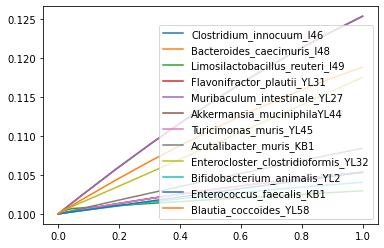

In [16]:
full_community["Microbes"].T.plot()

Here, we show when re-optimizations needed to happen:

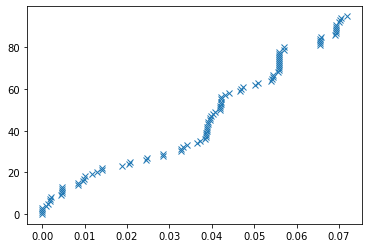

In [17]:
plt.plot(list(full_community["BasisChanges"].columns),np.arange(full_community["BasisChanges"].shape[1]),'x')

The "Combined" dataframe of the "SpcMetNetworkSummaries" presents the entire sequence of networks.

In [18]:
full_community["SpcMetNetworkSummaries"]["Combined"]["edges"]

,0.0000-0.0000,0.0010-0.0014,0.0014-0.0018,0.0018-0.0018,0.0018-0.0020,0.0020-0.0045,0.0045-0.0046,0.0047-0.0047,0.0047-0.0048,0.0084-0.0085,...,0.0656-0.0657,0.0657-0.0690,0.0690-0.0693,0.0693-0.0693,0.0693-0.0701,0.0701-0.0704,0.0704-0.0718,0.0718-1.0000,Source,Target
Riboflavin##Turicimonas_muris_YL45##Metabolite,126.689074,126.689074,126.689074,126.689074,126.689074,126.689074,126.689074,126.689074,126.689074,126.689074,...,126.689074,126.689074,126.689074,126.689074,126.689074,126.689074,126.689074,126.689074,Riboflavin,Turicimonas_muris_YL45
Flavonifractor_plautii_YL31##L-Glutamate-e0##Microbe,-68.228647,-68.228647,-68.228647,-68.228647,-68.228647,-68.228647,-68.228647,-68.228647,-68.228647,-255.804973,...,-2827.160648,-2827.160648,-2827.160648,-2827.160648,-2827.160648,-2827.160648,-2827.160648,-2827.160648,Flavonifractor_plautii_YL31,L-Glutamate-e0
Clostridium_innocuum_I46##L-Valine-e0##Microbe,3772.268632,3772.268632,2.355033,2.355033,2.355033,3.355033,3.355033,3.355033,3.355033,3.355033,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Clostridium_innocuum_I46,L-Valine-e0
Clostridium_innocuum_I46##K+-e0##Microbe,-0.924111,-0.924111,-0.924111,-0.924111,-0.924111,-0.924111,-0.924111,-0.924111,-0.924111,-0.924111,...,-0.924111,-0.924111,-0.924111,-0.924111,-0.924111,-0.924111,-0.924111,-0.924111,Clostridium_innocuum_I46,K+-e0
Limosilactobacillus_reuteri_I49##NH3-e0##Microbe,2407.763321,2407.263321,2407.263321,2694.983538,2694.983538,2694.483538,-10773.446662,-5402.440011,187.968271,187.968271,...,2252.902284,2252.902284,2252.902284,2252.902284,2252.902284,2252.902284,2252.902284,2252.902284,Limosilactobacillus_reuteri_I49,NH3-e0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Heme-e0##Limosilactobacillus_reuteri_I49##Metabolite,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Heme-e0,Limosilactobacillus_reuteri_I49
Clostridium_innocuum_I46##NH3-e0##Microbe,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-42.588226,-42.588226,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,Clostridium_innocuum_I46,NH3-e0
"Flavonifractor_plautii_YL31##1,3-Propanediol-e0##Microbe",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.954395,3.954395,3.954395,3.954395,3.954395,3.954395,3.954395,3.954395,Flavonifractor_plautii_YL31,"1,3-Propanediol-e0"
Clostridium_innocuum_I46##Butyrate-e0##Microbe,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,Clostridium_innocuum_I46,Butyrate-e0


We might be interested in how the network changed over time (recall that the network is piecewise constant, but changes at discrete time points). The "Difference" dataframe shows us this. Here, we sort the edges by total variation so that we can show the top N in a heatmap:

Values are new network edge weight minus old, so a positive number indicates an increase (more positive) edge.

In [64]:
ediff_df = full_community["SpcMetNetworkSummaries"]["Difference"]["edges"]
ediff_df_num = ediff_df.select_dtypes(include='number')
ediff_df_num.abs().sum(axis=1).sort_values(ascending=False)
ediff_df_srt = ediff_df_num.loc[ediff_df_num.abs().sum(axis=1).sort_values(ascending=False).index]
# ediff_df_num[ediff_df_num.abs().sum(axis=1) > 1]

In [65]:
ediff_df_srt.head()

,0.0000,0.0014,0.0018,0.0020,0.0045,0.0046,0.0047,0.0048,0.0085,0.0096,...,0.0559,0.0570,0.0655,0.0656,0.0657,0.0690,0.0693,0.0701,0.0704,0.0718
Limosilactobacillus_reuteri_I49##Sorbitol-e0##Microbe,1.0,0.000000,0.000000e+00,0.0,37710.204558,-26870.033253,-11180.816563,-5.569518e-09,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000,0.000000,0.0
Limosilactobacillus_reuteri_I49##D-Lactate-e0##Microbe,0.0,0.000000,0.000000e+00,0.0,-32323.032479,15914.122770,11180.816563,3.760749e+03,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000,0.000000,0.0
Limosilactobacillus_reuteri_I49##D-Glucose-e0##Microbe,-0.5,0.000000,0.000000e+00,0.5,-29629.446438,21496.026602,11180.816563,-1.880374e+03,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000,0.000000,0.0
Clostridium_innocuum_I46##CO2-e0##Microbe,0.0,-5654.870398,-1.160743e-10,0.5,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-11.88235,-332.949105,-20.582,11.008724,0.0
Limosilactobacillus_reuteri_I49##CO2-e0##Microbe,0.0,0.000000,0.000000e+00,0.0,16161.516239,-10749.013301,-5590.408282,-2.809998e-09,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000,0.000000,0.0


<AxesSubplot:>

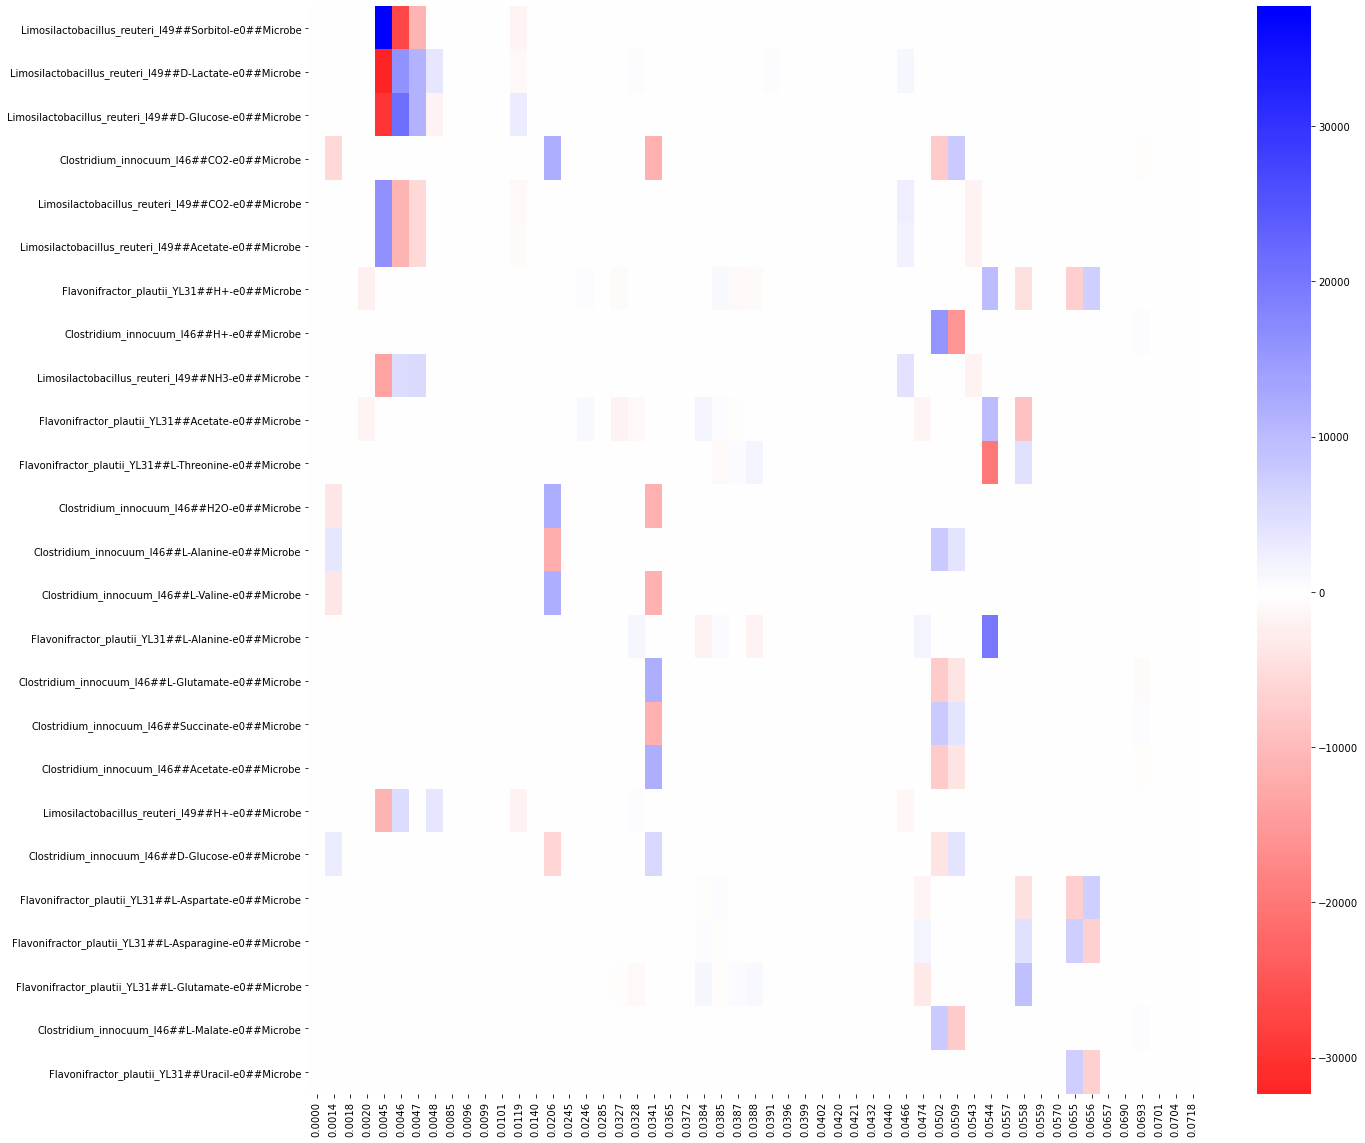

In [66]:
fig,ax = plt.subplots(figsize=(20,20))
sb.heatmap(ediff_df_srt.head(25),center=0,cmap='bwr_r')

In [147]:
spc_net = full_community['SpeciesNetwork']['Average']['edges']
spc_adj = pd.DataFrame(index = spc,columns = spc)
for rwi in spc_net.index:
    rw = spc_net.loc[rwi]
    spc_adj.loc[rw["Source"],rw["Target"]] = rw["Weight"]

<AxesSubplot:>

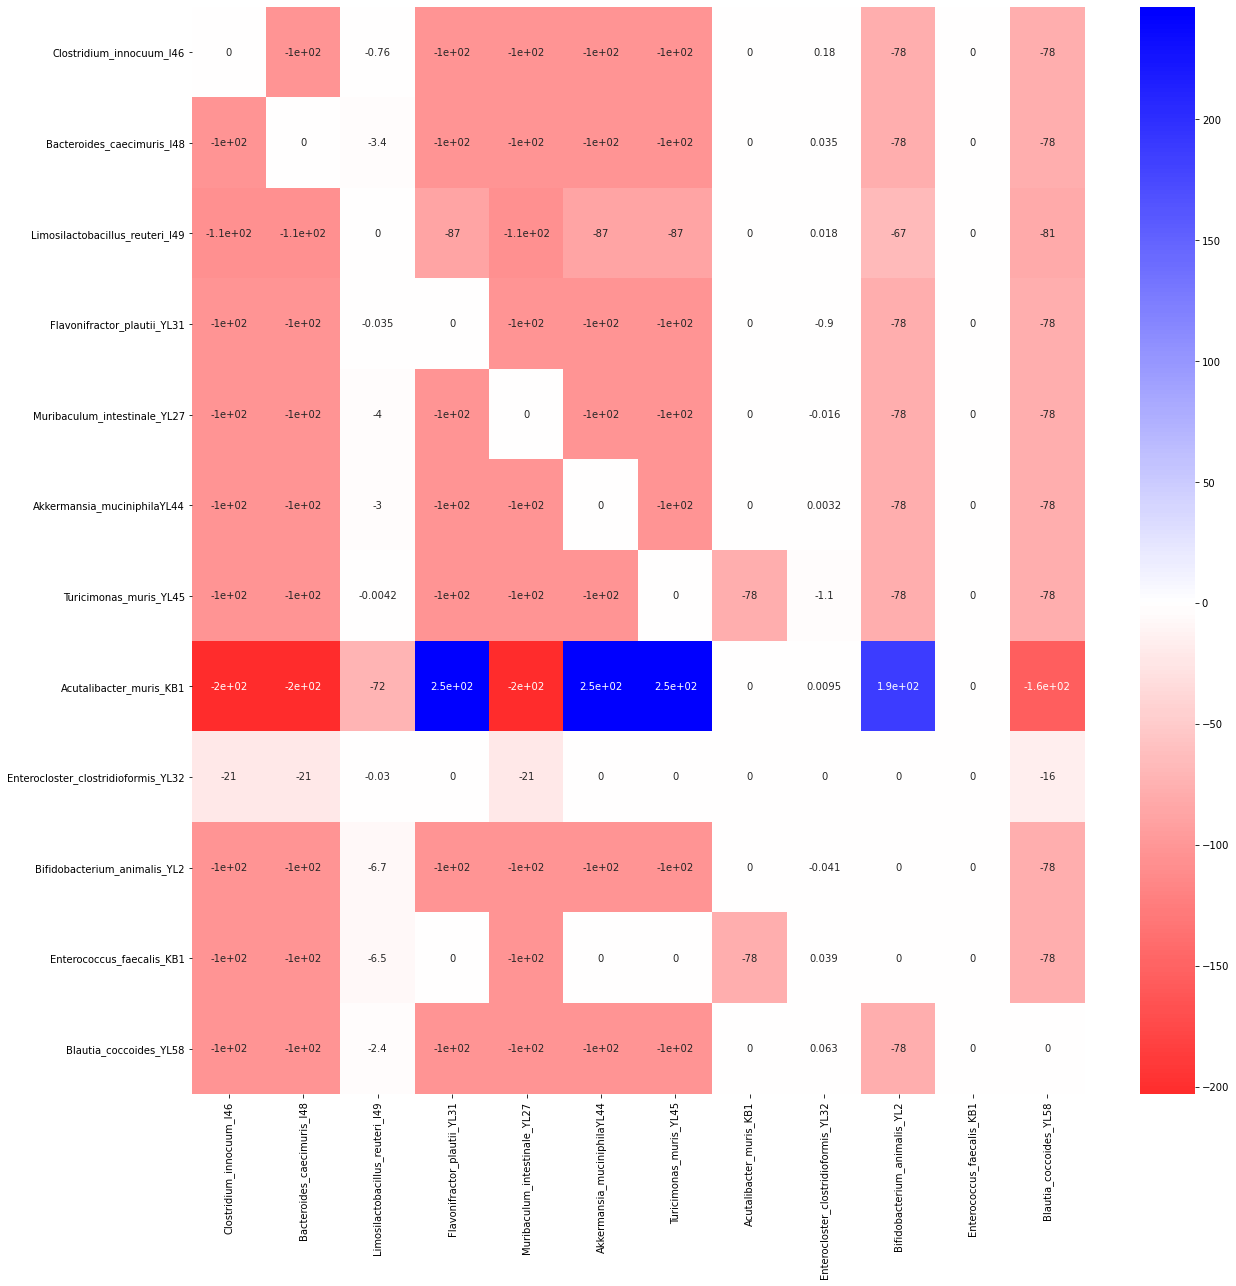

In [148]:
fig,ax = plt.subplots(figsize=(20,20))
sb.heatmap(spc_adj.fillna(0),center=0,cmap='bwr_r',annot = True,ax=ax)

In [70]:
full_community['SpeciesNetwork']['0.0000-0.0000']['adjacency']

Name,Clostridium_innocuum_I46,Bacteroides_caecimuris_I48,Limosilactobacillus_reuteri_I49,Flavonifractor_plautii_YL31,Muribaculum_intestinale_YL27,Akkermansia_muciniphilaYL44,Turicimonas_muris_YL45,Acutalibacter_muris_KB1,Enterocloster_clostridioformis_YL32,Bifidobacterium_animalis_YL2,Enterococcus_faecalis_KB1,Blautia_coccoides_YL58
Name,,,,,,,,,,,,
Clostridium_innocuum_I46,0,-126.689074,-126.689074,-126.689074,-126.689074,-126.689074,-126.689074,-253.378148,-126.689074,-126.689074,-126.689074,-126.689074
Bacteroides_caecimuris_I48,-126.689074,0,-126.689074,-126.689074,-126.689074,-126.689074,-126.689074,-253.378148,-126.689074,-126.689074,-126.689074,-126.689074
Limosilactobacillus_reuteri_I49,-96.796147,-96.796147,0,-96.796147,-96.796147,-96.796147,-96.796147,-193.592293,-96.796147,-96.796147,-96.796147,-96.796147
Flavonifractor_plautii_YL31,-126.689074,-126.689074,-126.689074,0,-126.689074,-126.689074,-126.689074,307.760873,NaN,-126.689074,NaN,-126.689074
Muribaculum_intestinale_YL27,-126.689074,-126.689074,-126.689074,-126.689074,0,-126.689074,-126.689074,-253.378148,-126.689074,-126.689074,-126.689074,-126.689074
Akkermansia_muciniphilaYL44,-126.689074,-126.689074,-126.689074,-126.689074,-126.689074,0,-126.689074,307.760873,NaN,-126.689074,NaN,-126.689074
Turicimonas_muris_YL45,-126.689074,-126.689074,-126.689074,-126.689074,-126.689074,-126.689074,0,307.760873,NaN,-126.689074,NaN,-126.689074
Acutalibacter_muris_KB1,NaN,NaN,NaN,NaN,NaN,NaN,-96.796147,0,NaN,NaN,-96.796147,NaN
Enterocloster_clostridioformis_YL32,-126.689074,-126.689074,-126.689074,-126.689074,-126.689074,-126.689074,-126.689074,-253.378148,0,-126.689074,-126.689074,-126.689074


<AxesSubplot:xlabel='Name', ylabel='Name'>

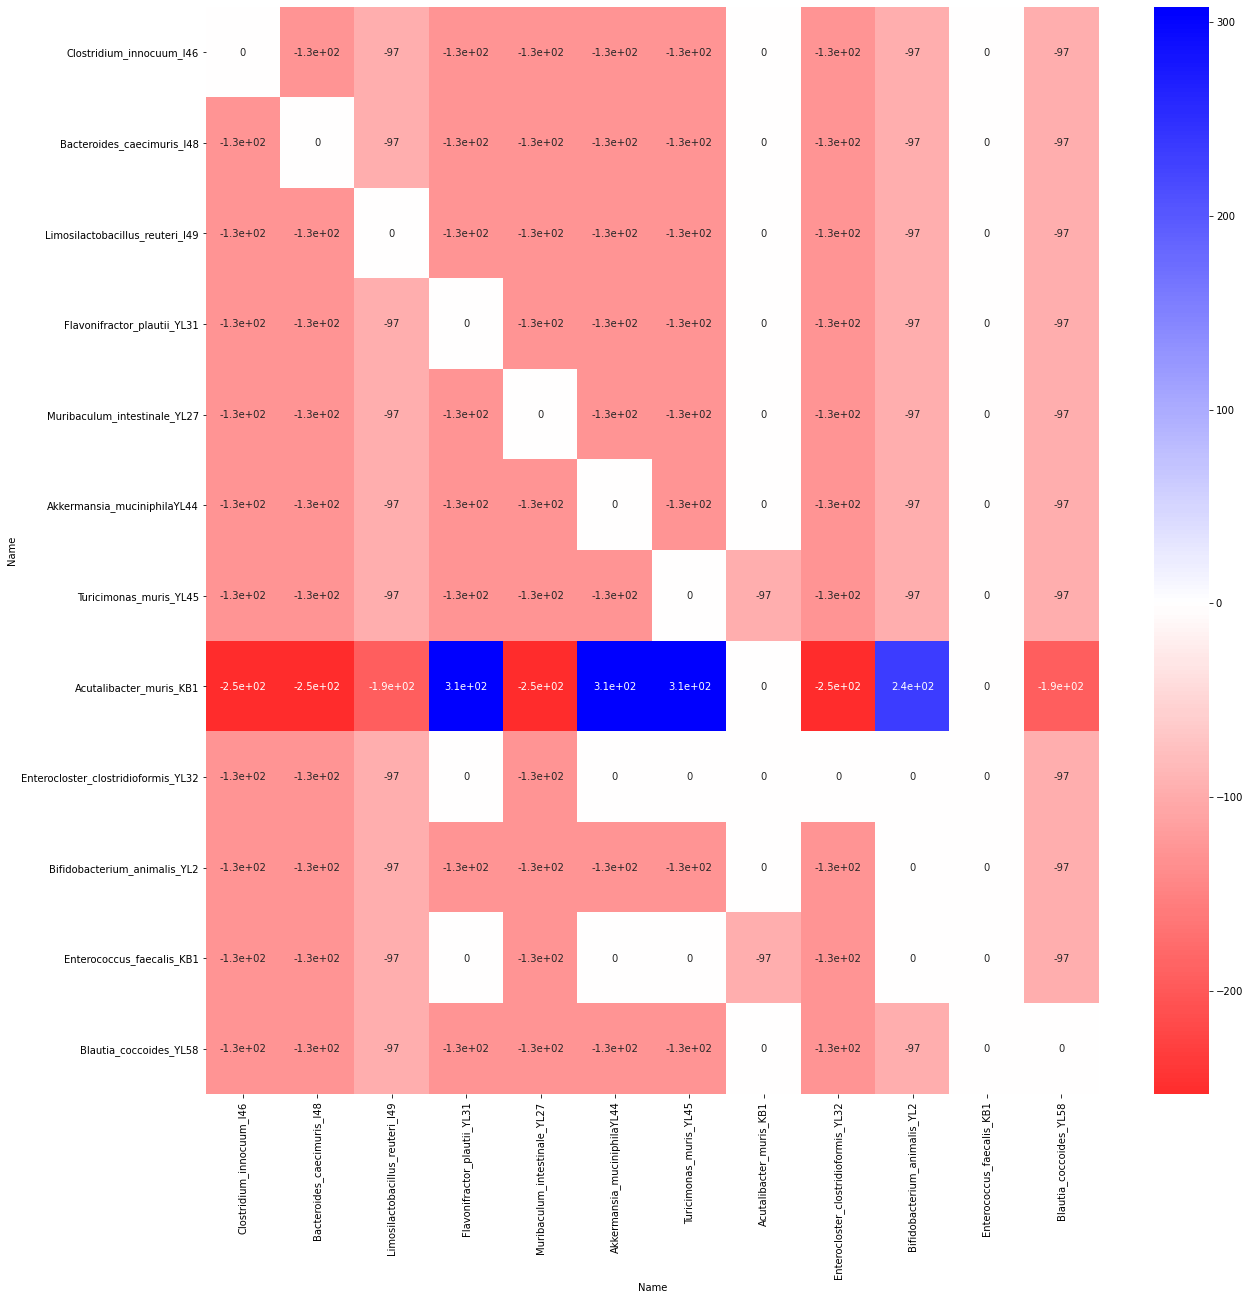

In [231]:
fig,ax = plt.subplots(figsize=(20,20))
sb.heatmap(full_community['SpeciesNetwork']['0.0000-0.0000']['adjacency'].T.fillna(0),center=0,cmap='bwr_r',annot = True,ax=ax)

In [77]:
weiss_growth_72_hrs = pd.read_excel("41396_2021_1153_MOESM2_ESM.xlsx",sheet_name="coculture abs abundance 72h")

In [79]:
weiss_growth_72_hrs

,coculture,probe,exp1_copies/5ng gDNA (16Scorrected),exp2_copies/5ng gDNA (16Scorrected),exp3_copies/5ng gDNA (16Scorrected)
0,I46 Mono,I46,482750,352500,487750
1,YL27I46,I46,663500,682500,432500
2,YL44I46,I46,241425,652500,235775
3,YL31I46,I46,365000,550000,377750
4,YL32I46,I46,314750,675000,403000
...,...,...,...,...,...
139,YL31YL58,YL58,-,1626000,1905800
140,YL32YL58,YL58,1228800,840000,837000
141,I49YL58,YL58,1351600,2000000,1644400
142,I46YL58,YL58,1577200,1962000,1916000


In [103]:
strain_abbv = {}
for sp in spc:
    strain_abbv[sp] = sp.split("_")[-1]
strain_abbv['Akkermansia_muciniphilaYL44'] = "YL44"

In [144]:
growth_log_ratio = pd.DataFrame(index = spc,columns = spc)
for trg in spc:
    trgdf = weiss_growth_72_hrs[[p in trg for p in weiss_growth_72_hrs["probe"]]]
    mono = trgdf[["Mono" in co for co in trgdf['coculture']]]
    for src in spc:
        if src != trg:
            srcdf = trgdf[[strain_abbv[src] in co for co in trgdf['coculture']]]
            if len(srcdf):
                try:
                    exp1_ratio = np.log(srcdf["exp1_copies/5ng gDNA (16Scorrected)"].iloc[0]) - np.log(mono["exp1_copies/5ng gDNA (16Scorrected)"].iloc[0])
                    exp2_ratio = np.log(srcdf["exp2_copies/5ng gDNA (16Scorrected)"].iloc[0]) - np.log(mono["exp2_copies/5ng gDNA (16Scorrected)"].iloc[0])
                    exp3_ratio = np.log(srcdf["exp3_copies/5ng gDNA (16Scorrected)"].iloc[0]) - np.log(mono["exp3_copies/5ng gDNA (16Scorrected)"].iloc[0])
                    growth_log_ratio.loc[src,trg] = (exp1_ratio + exp2_ratio + exp3_ratio)/3
                except TypeError:
                    growth_log_ratio.loc[src,trg] = 0
            else:
                growth_log_ratio.loc[src,trg] = 0
        else:
            growth_log_ratio.loc[src,trg] = 0

In [145]:
growth_log_ratio

,Clostridium_innocuum_I46,Bacteroides_caecimuris_I48,Limosilactobacillus_reuteri_I49,Flavonifractor_plautii_YL31,Muribaculum_intestinale_YL27,Akkermansia_muciniphilaYL44,Turicimonas_muris_YL45,Acutalibacter_muris_KB1,Enterocloster_clostridioformis_YL32,Bifidobacterium_animalis_YL2,Enterococcus_faecalis_KB1,Blautia_coccoides_YL58
Clostridium_innocuum_I46,0,-1.201279,0,-1.398471,-1.596312,-7.050416,-0.781016,1.157542,-3.364959,-1.596312,1.157542,-0.127029
Bacteroides_caecimuris_I48,-0.219868,0,-2.99432,-0.472275,-1.464635,-7.86185,-0.054879,-0.278822,-2.697598,-1.464635,-0.278822,-0.338877
Limosilactobacillus_reuteri_I49,-0.141953,0.054962,0,-0.828074,-0.918044,-5.942398,0.279071,-0.405551,-2.874766,-0.918044,-0.405551,-0.223043
Flavonifractor_plautii_YL31,-0.030101,-0.269414,-12.951567,0,-1.674099,-0.416935,-0.088095,0.503143,0,-1.674099,0.503143,0
Muribaculum_intestinale_YL27,0.286174,-0.048757,-1.790152,-0.345883,0,-4.827837,0.461085,0.3164,-1.930551,-0.537038,0.3164,-0.236389
Akkermansia_muciniphilaYL44,-0.268035,-0.484632,-0.631164,-0.492796,0,0,-0.206979,0.522449,-2.266622,0,0.522449,-0.439929
Turicimonas_muris_YL45,0.177688,-0.043123,-0.351514,-0.143223,-1.69507,-0.333302,0,0.255321,-2.270084,-1.69507,0.255321,-0.440955
Acutalibacter_muris_KB1,0.038295,-3.115763,0.05297,0.122264,-4.792411,-0.078401,0.47397,0,-2.217183,-4.792411,0.143022,-0.42855
Enterocloster_clostridioformis_YL32,0.010358,-0.289775,-0.789224,-1.891468,-1.511479,-7.139403,-0.358377,0.241829,0,-1.511479,0.241829,-0.769062
Bifidobacterium_animalis_YL2,0.286174,-0.048757,-1.790152,-0.345883,-4.792411,-6.356738,0,0.143022,-3.937458,0,0.143022,-0.236389


<AxesSubplot:>

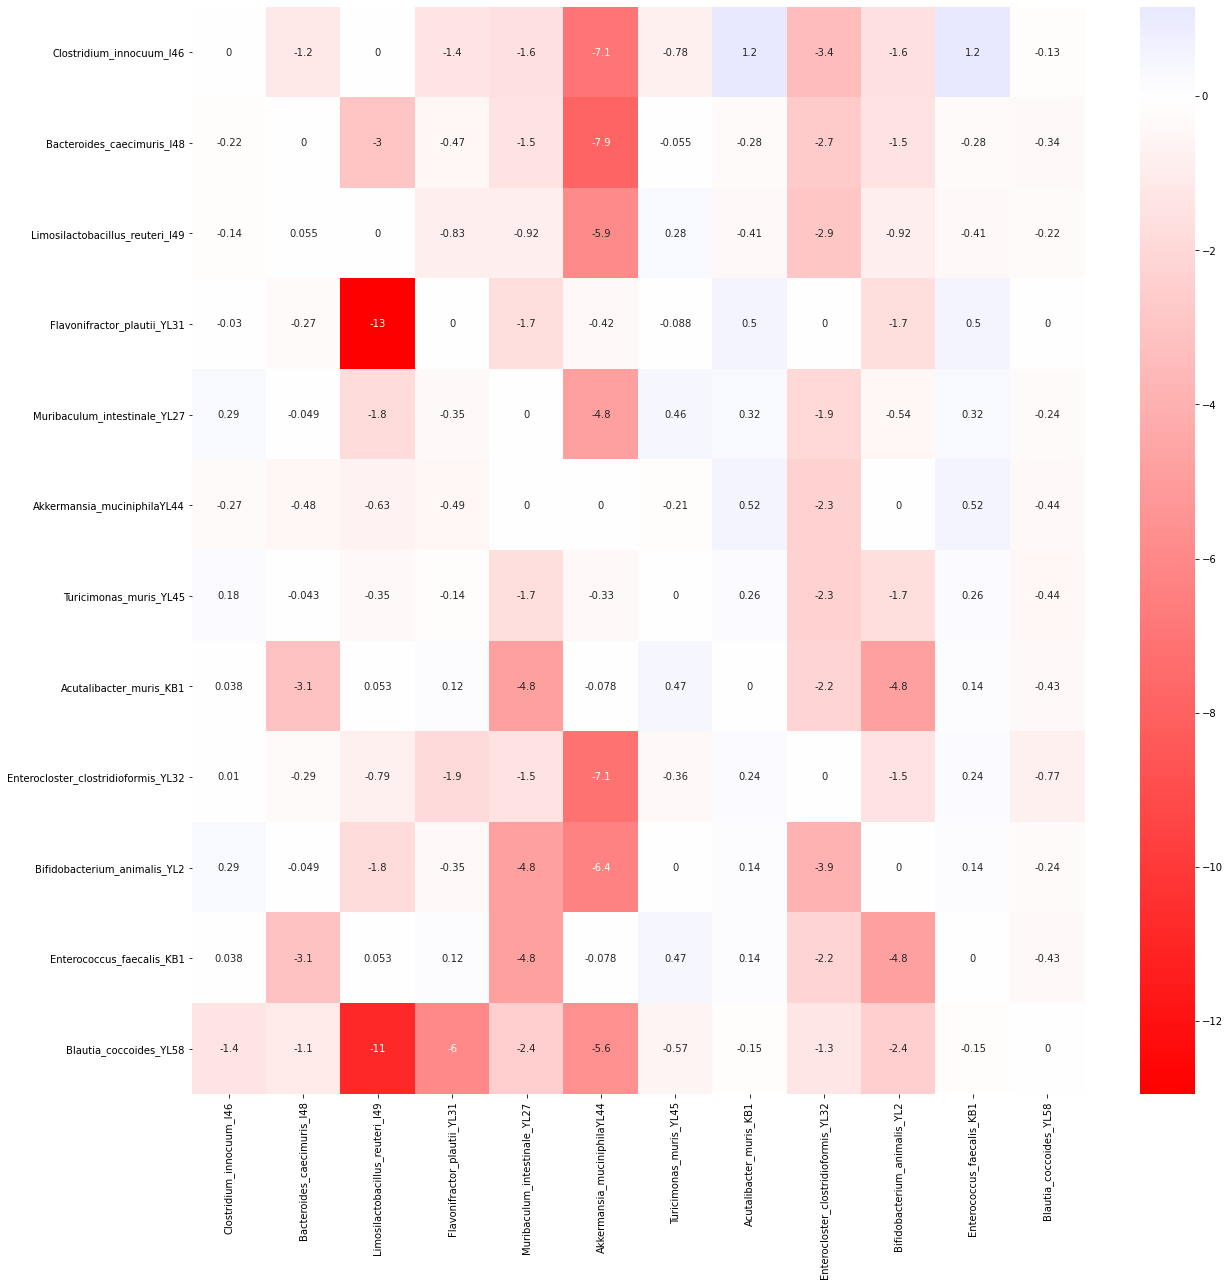

In [146]:
fig,ax = plt.subplots(figsize=(20,20))
sb.heatmap(growth_log_ratio.fillna(0),center=0,cmap='bwr_r',annot = True,ax=ax)

In [159]:
c = 10**-2

<AxesSubplot:>

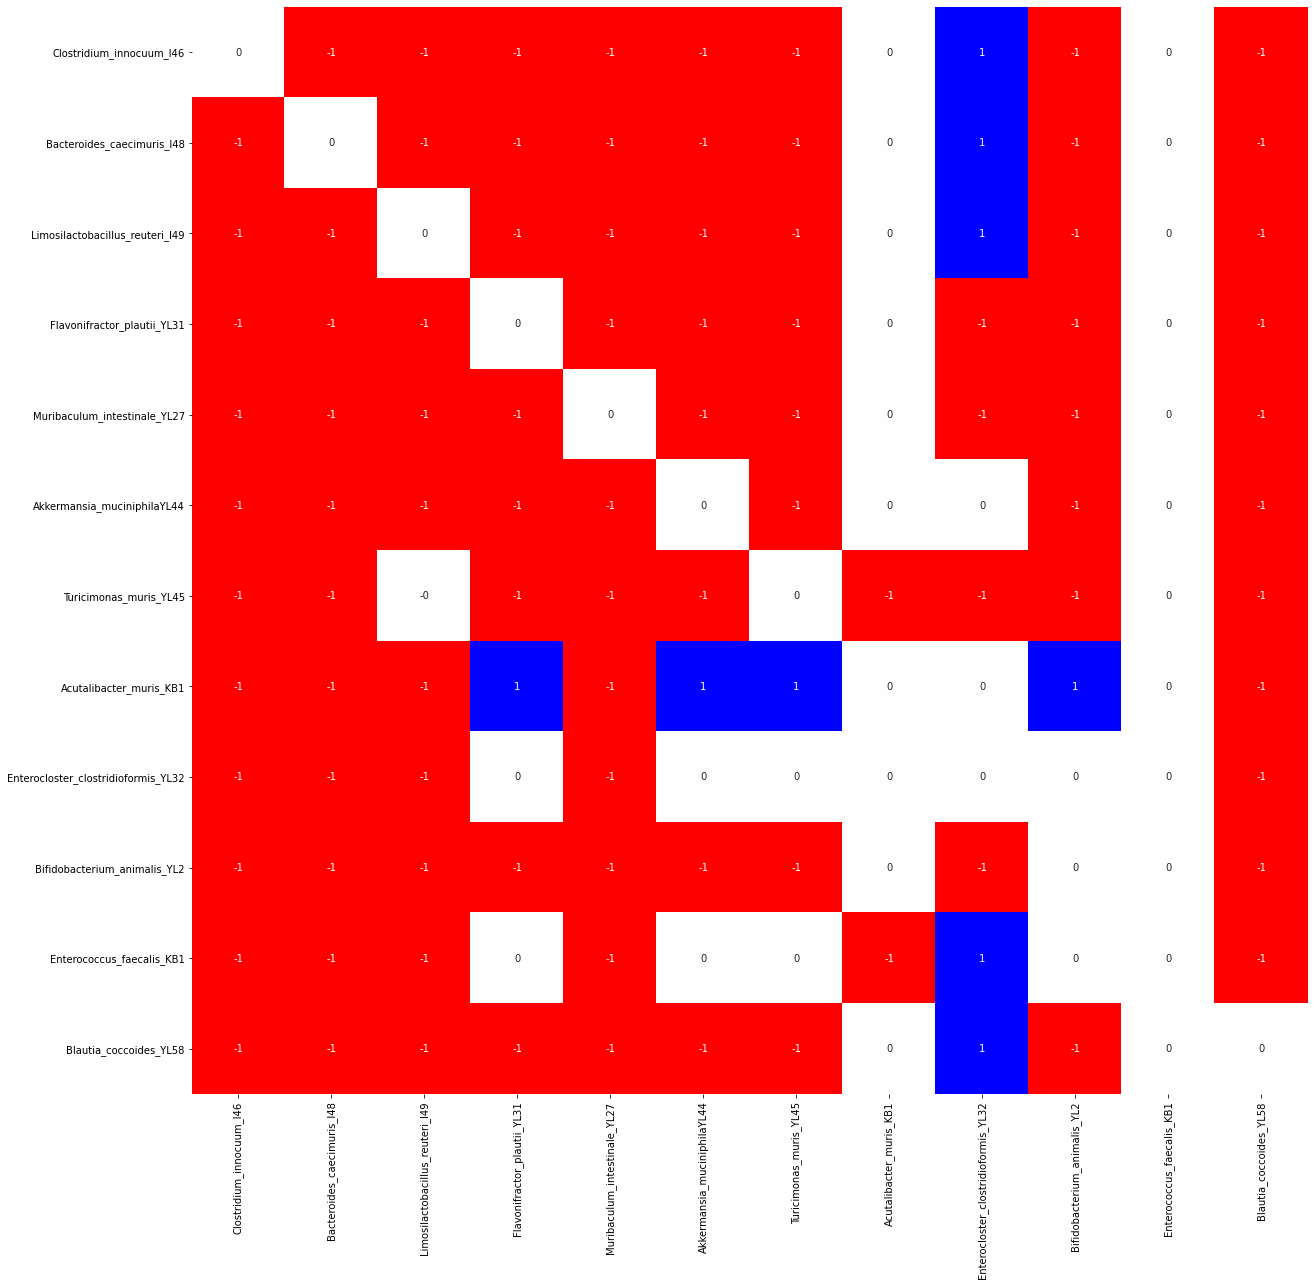

In [184]:
fig,ax = plt.subplots(figsize=(20,20))
sb.heatmap(np.sign(spc_adj.fillna(0))*(spc_adj.fillna(0).abs() > c),center=0,cmap='bwr_r',annot = True,ax=ax,cbar = False)

<AxesSubplot:>

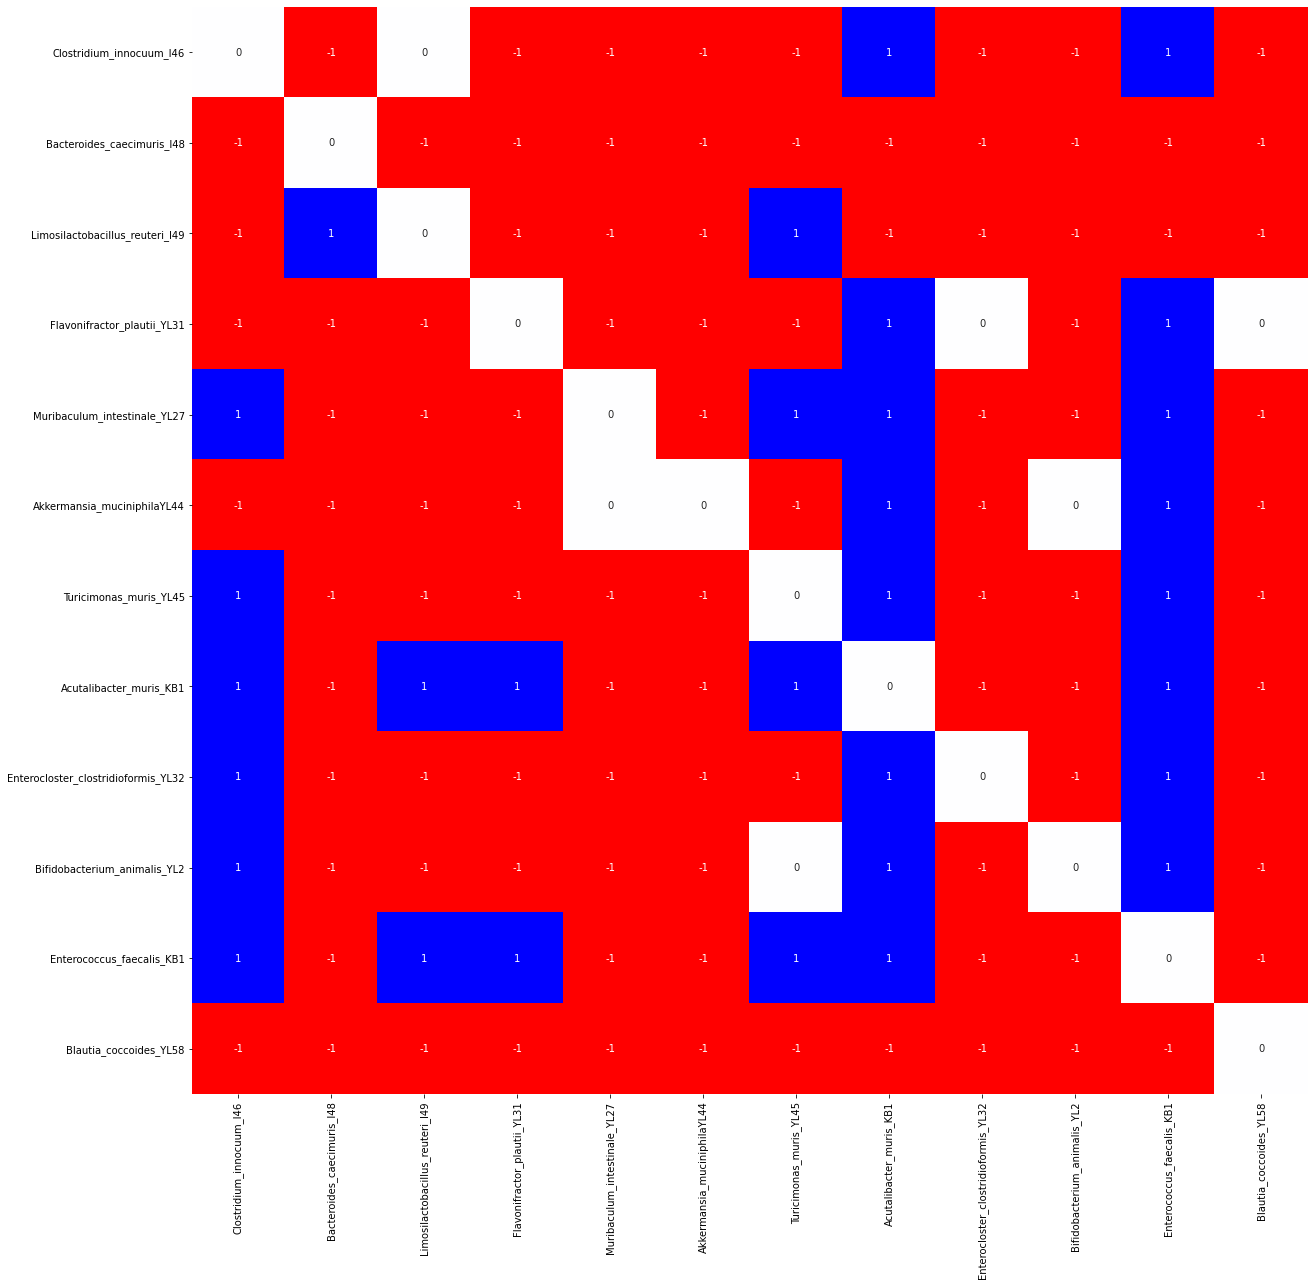

In [182]:
fig,ax = plt.subplots(figsize=(20,20))
sb.heatmap(np.sign(growth_log_ratio.fillna(0))*(growth_log_ratio.fillna(0).abs() > c),center=0,cmap='bwr_r',annot = True,ax=ax,cbar = False)

In [180]:
comp = (np.sign(spc_adj.fillna(0))*(spc_adj.fillna(0).abs() > c))-(np.sign(growth_log_ratio)*(growth_log_ratio.fillna(0).abs() > c))

<AxesSubplot:>

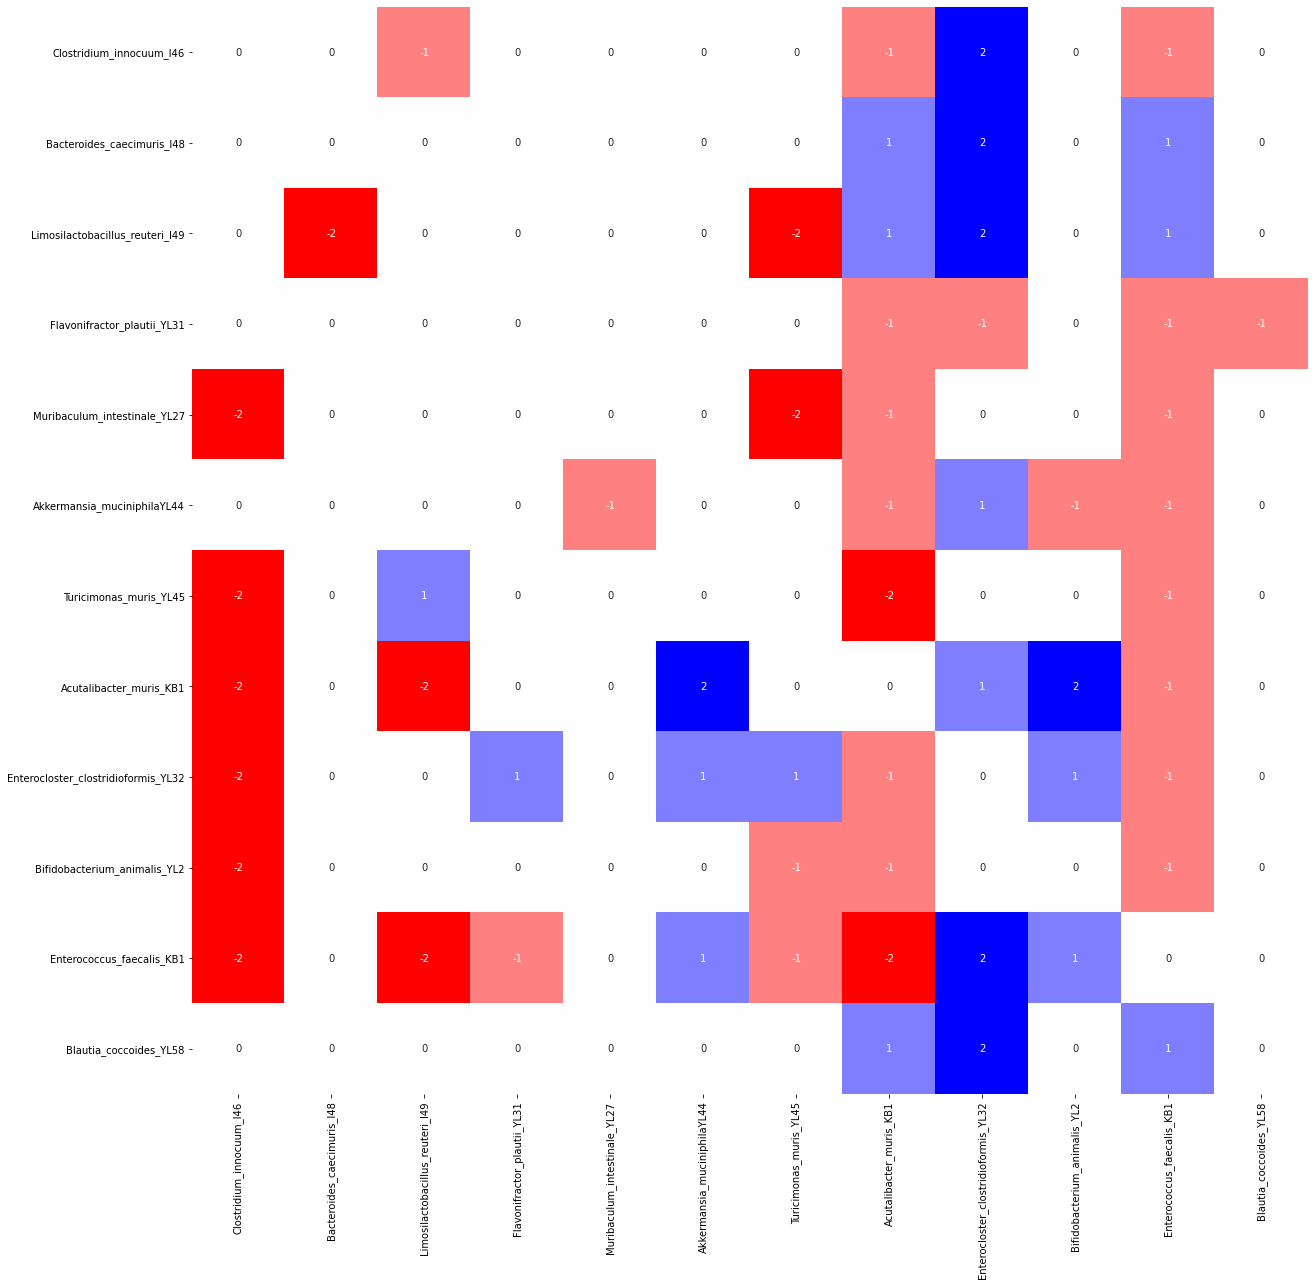

In [181]:
fig,ax = plt.subplots(figsize=(20,20))
sb.heatmap(comp.fillna(0),center=0,cmap='bwr_r',annot = True,ax=ax,cbar = False)

In [175]:
full_community['SpeciesNetwork'].keys()

dict_keys(['0.0000-0.0000', '0.0010-0.0014', '0.0014-0.0018', '0.0018-0.0018', '0.0018-0.0020', '0.0020-0.0045', '0.0045-0.0046', '0.0047-0.0047', '0.0047-0.0048', '0.0084-0.0085', '0.0085-0.0096', '0.0096-0.0099', '0.0099-0.0101', '0.0101-0.0119', '0.0130-0.0140', '0.0140-0.0140', '0.0188-0.0206', '0.0208-0.0245', '0.0245-0.0246', '0.0246-0.0285', '0.0285-0.0327', '0.0327-0.0328', '0.0331-0.0341', '0.0341-0.0365', '0.0365-0.0372', '0.0372-0.0384', '0.0384-0.0385', '0.0386-0.0387', '0.0387-0.0388', '0.0388-0.0388', '0.0388-0.0391', '0.0391-0.0391', '0.0396-0.0396', '0.0396-0.0399', '0.0399-0.0402', '0.0406-0.0420', '0.0420-0.0420', '0.0420-0.0421', '0.0421-0.0421', '0.0423-0.0432', '0.0432-0.0440', '0.0440-0.0466', '0.0468-0.0474', '0.0474-0.0502', '0.0502-0.0509', '0.0539-0.0543', '0.0543-0.0544', '0.0544-0.0557', '0.0557-0.0558', '0.0558-0.0558', '0.0559-0.0559', '0.0559-0.0570', '0.0570-0.0570', '0.0570-0.0655', '0.0655-0.0656', '0.0656-0.0656', '0.0656-0.0657', '0.0657-0.0690', '0.

In [232]:
tmadj = full_community['SpeciesNetwork']['0.0010-0.0014']['adjacency'].T

In [233]:
comp = (np.sign(tmadj.fillna(0))*(tmadj.fillna(0).abs() > c))-(np.sign(growth_log_ratio)*(growth_log_ratio.fillna(0).abs() > c))

<AxesSubplot:xlabel='Name', ylabel='Name'>

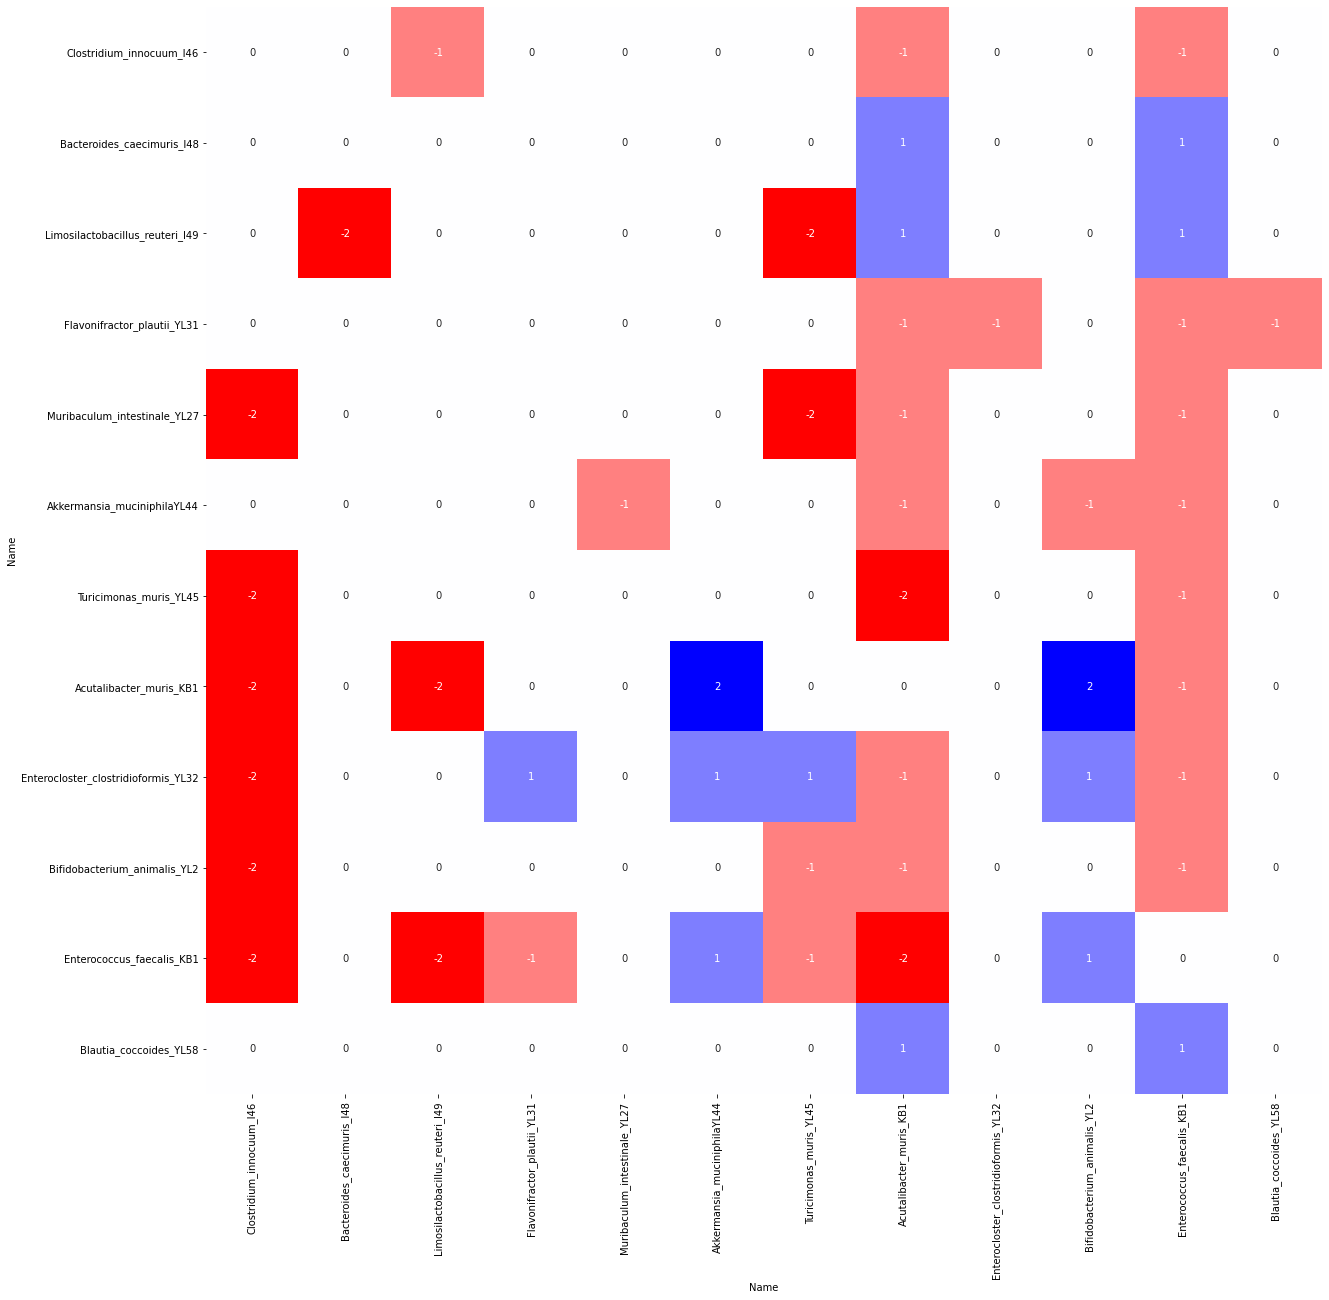

In [234]:
fig,ax = plt.subplots(figsize=(20,20))
sb.heatmap(comp.fillna(0),center=0,cmap='bwr_r',annot = True,ax=ax,cbar = False)

In [235]:
count_incoming = {}
kys = [ky for ky in full_community['SpeciesNetwork'].keys() if ky not in ["Average","Difference","Combined"]]
for n in [-2,-1,0,1,2]:
    count_incoming[n] = pd.DataFrame(index = spc,columns = kys)
for ky in kys:
    tmadj = full_community['SpeciesNetwork'][ky]['adjacency'].T
    comp = (np.sign(tmadj.fillna(0))*(tmadj.fillna(0).abs() > c))-(np.sign(growth_log_ratio)*(growth_log_ratio.fillna(0).abs() > c))
    for n in [-2,-1,0,1,2]:
        count_incoming[n][ky] = (comp==n).sum()/(len(spc)-1)
total_wrong_incoming = count_incoming[-2] + count_incoming[-1] + count_incoming[1] + count_incoming[2]
total_opposite_incoming = count_incoming[-2] + count_incoming[2]

In [236]:
total_wrong_incoming.mean(axis = 1)

Clostridium_innocuum_I46               0.541193
Bacteroides_caecimuris_I48             0.095170
Limosilactobacillus_reuteri_I49        0.723011
Flavonifractor_plautii_YL31            0.183239
Muribaculum_intestinale_YL27           0.095170
Akkermansia_muciniphilaYL44            0.274148
Turicimonas_muris_YL45                 0.453125
Acutalibacter_muris_KB1                1.000000
Enterocloster_clostridioformis_YL32    0.747159
Bifidobacterium_animalis_YL2           0.365057
Enterococcus_faecalis_KB1              1.000000
Blautia_coccoides_YL58                 0.095170
dtype: float64

<AxesSubplot:>

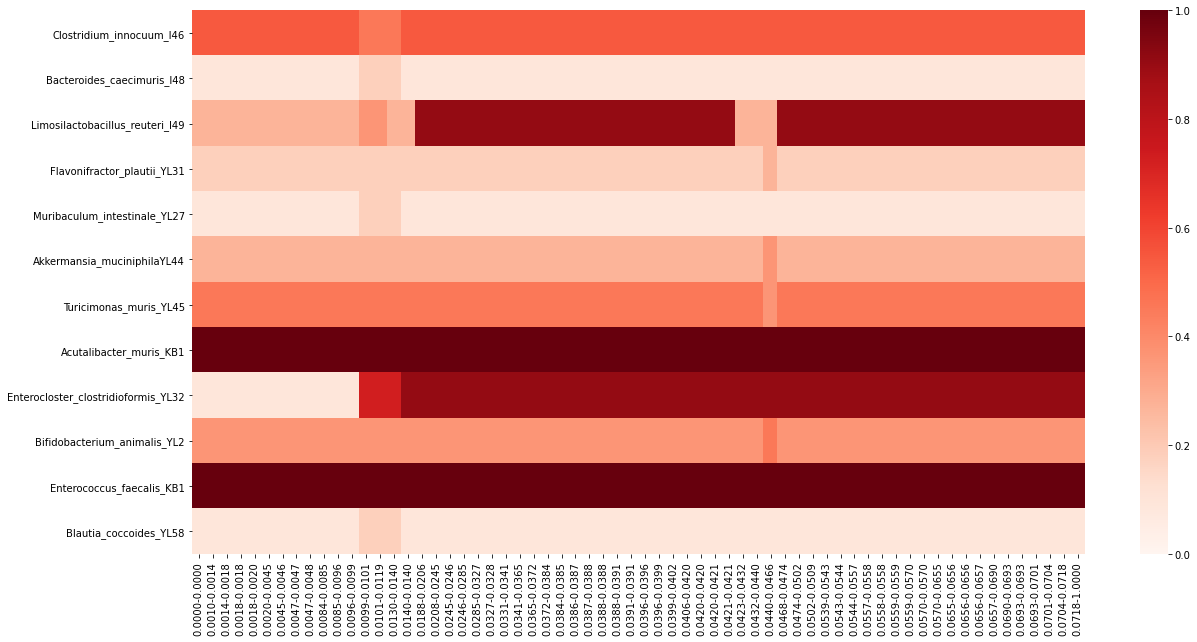

In [237]:
fig,ax = plt.subplots(figsize=(20,10))
sb.heatmap(total_wrong_incoming,cmap='Reds',annot = False,ax=ax,cbar = True,vmin=0,vmax=1)

In [238]:
total_opposite_incoming.mean(axis = 1)

Clostridium_innocuum_I46               0.541193
Bacteroides_caecimuris_I48             0.095170
Limosilactobacillus_reuteri_I49        0.120739
Flavonifractor_plautii_YL31            0.001420
Muribaculum_intestinale_YL27           0.004261
Akkermansia_muciniphilaYL44            0.092330
Turicimonas_muris_YL45                 0.180398
Acutalibacter_muris_KB1                0.181818
Enterocloster_clostridioformis_YL32    0.029830
Bifidobacterium_animalis_YL2           0.092330
Enterococcus_faecalis_KB1              0.000000
Blautia_coccoides_YL58                 0.004261
dtype: float64

<AxesSubplot:>

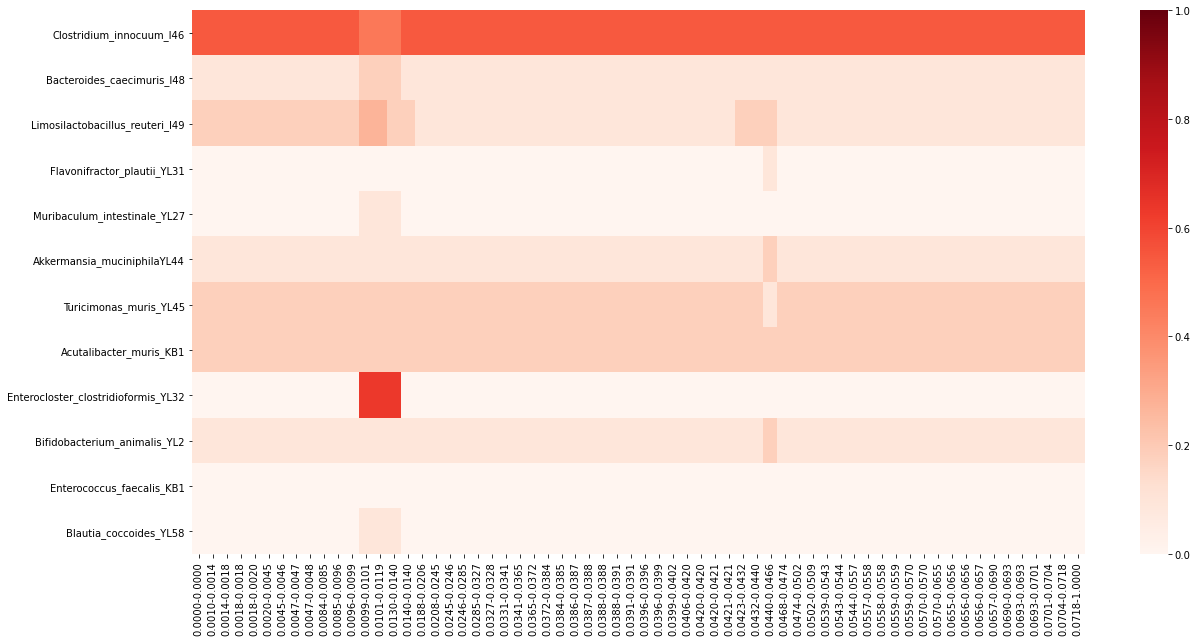

In [239]:
fig,ax = plt.subplots(figsize=(20,10))
sb.heatmap(total_opposite_incoming,cmap='Reds',annot = False,ax=ax,cbar = True,vmin=0,vmax=1)

In [240]:
count_outgoing = {}
kys = [ky for ky in full_community['SpeciesNetwork'].keys() if ky not in ["Average","Difference","Combined"]]
for n in [-2,-1,0,1,2]:
    count_outgoing[n] = pd.DataFrame(index = spc,columns = kys)
for ky in kys:
    tmadj = full_community['SpeciesNetwork'][ky]['adjacency'].T
    comp = (np.sign(tmadj.fillna(0))*(tmadj.fillna(0).abs() > c))-(np.sign(growth_log_ratio)*(growth_log_ratio.fillna(0).abs() > c))
    for n in [-2,-1,0,1,2]:
        count_outgoing[n][ky] = (comp==n).T.sum()/(len(spc)-1)
total_wrong_outgoing = count_outgoing[-2] + count_outgoing[-1] + count_outgoing[1] + count_outgoing[2]
total_opposite_outgoing = count_outgoing[-2] + count_outgoing[2]

In [241]:
total_wrong_outgoing.mean(axis = 1)

Clostridium_innocuum_I46               0.282670
Bacteroides_caecimuris_I48             0.319602
Limosilactobacillus_reuteri_I49        0.440341
Flavonifractor_plautii_YL31            0.357955
Muribaculum_intestinale_YL27           0.497159
Akkermansia_muciniphilaYL44            0.501420
Turicimonas_muris_YL45                 0.406250
Acutalibacter_muris_KB1                0.528409
Enterocloster_clostridioformis_YL32    0.711648
Bifidobacterium_animalis_YL2           0.497159
Enterococcus_faecalis_KB1              0.710227
Blautia_coccoides_YL58                 0.319602
dtype: float64

<AxesSubplot:>

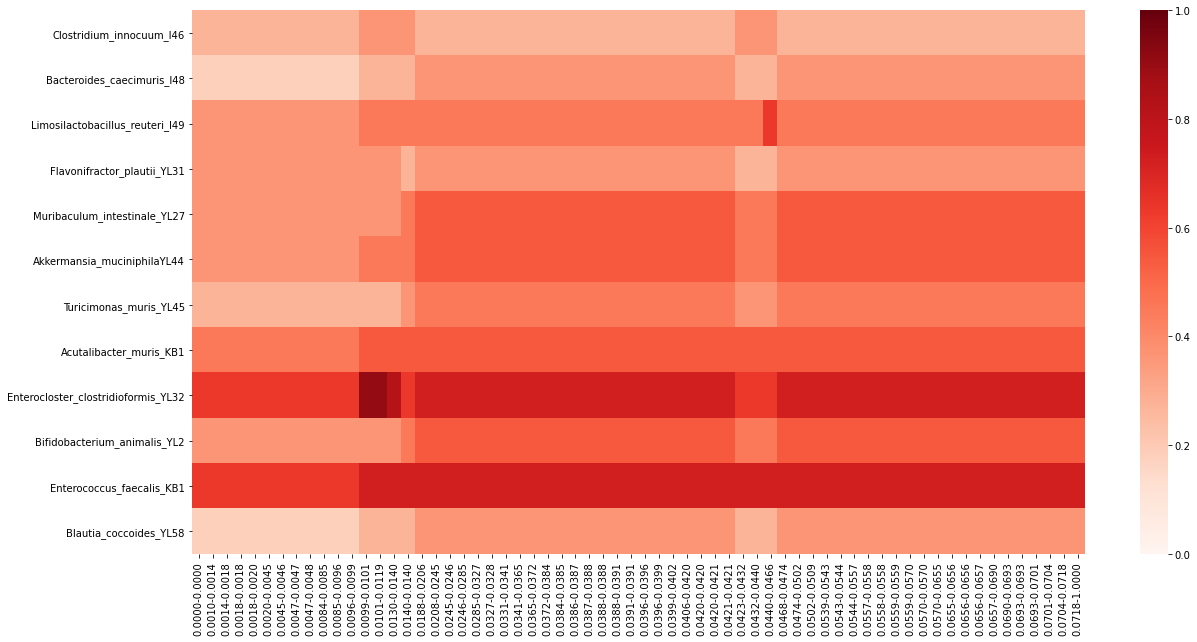

In [242]:
fig,ax = plt.subplots(figsize=(20,10))
sb.heatmap(total_wrong_outgoing,cmap='Reds',annot = False,ax=ax,cbar = True,vmin=0,vmax=1)

In [243]:
total_opposite_outgoing.mean(axis = 1)

Clostridium_innocuum_I46               0.004261
Bacteroides_caecimuris_I48             0.004261
Limosilactobacillus_reuteri_I49        0.188920
Flavonifractor_plautii_YL31            0.000000
Muribaculum_intestinale_YL27           0.181818
Akkermansia_muciniphilaYL44            0.004261
Turicimonas_muris_YL45                 0.181818
Acutalibacter_muris_KB1                0.335227
Enterocloster_clostridioformis_YL32    0.102273
Bifidobacterium_animalis_YL2           0.090909
Enterococcus_faecalis_KB1              0.245739
Blautia_coccoides_YL58                 0.004261
dtype: float64

<AxesSubplot:>

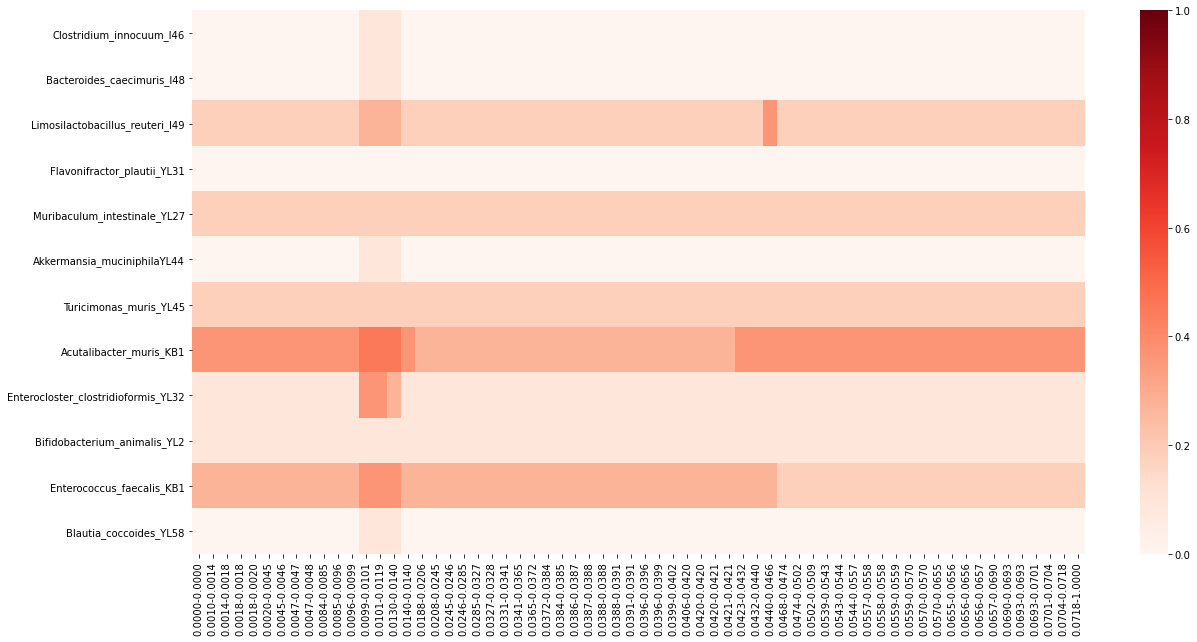

In [244]:
fig,ax = plt.subplots(figsize=(20,10))
sb.heatmap(total_opposite_outgoing,cmap='Reds',annot = False,ax=ax,cbar = True,vmin=0,vmax=1)

## Simulating Monocultures

In [22]:
monosims = {}
for sp in spc:
    monosims[sp] = metconsin.metconsin_sim([sp],model_info_flnm,media = env,initial_abundance = initial_abundance,metabolite_inflow = oxygen_in,endtime = et)

[MetConSIN] Loaded 1 models successfully
[MetConSIN] Clostridium_innocuum_I46 COBRA initial growth rate: 0.31314407570673186

[prep_cobrapy_models] Clostridium_innocuum_I46 Upper Bounds: Using linear uptake
[prep_cobrapy_models] Clostridium_innocuum_I46 Lower Bounds: Using constant uptake as defined in COBRA model file
surfin_fba: Initializing Simulation
Clostridium_innocuum_I46  [fba_gb] initializing LP
Clostridium_innocuum_I46  [fba_gb] Adding constraints
Clostridium_innocuum_I46  [fba_gb] optimizing LP
Clostridium_innocuum_I46  [fba_gb] optimizing with  5672  constraints
Clostridium_innocuum_I46  [fba_gb] LP Status:  OPTIMAL
Clostridium_innocuum_I46 [fba_gb] Initial Growth Rate: 0.31314407570599584
Clostridium_innocuum_I46 [fba_gb] Secondary Objective Value = 182.078133810966
Clostridium_innocuum_I46 [fba_gb] Distance from all_vars: 6.434156344355985e-08
Clostridium_innocuum_I46 [fba_gb] Start basis growth rate: 0.3131440757059636
 Start basis total flux: 182.07813394910238
Clostrid

surfin_fba: Solving IVP using Radau solver
surfin_fba: Finding New Basis at time  0.07175546512688681
surfin_fba: Solving IVP using Radau solver
surfin_fba: Finding New Basis at time  0.07175546526165304
surfin_fba: Solving IVP using Radau solver
surfin_fba: Done in 2 minutes, 40.847066164016724 seconds.
[MetConSIN] Simulation & Bases computed in  2  minutes,  46.75525188446045  seconds.
[species_metabolite_network] Building network
[species_metabolite_network] Network built in  0  minutes,  4.146944999694824  seconds.
[heuristic_ss] Target: Bacteroides_caecimuris_I48
[species_metabolite_network] Building network
[species_metabolite_network] Network built in  0  minutes,  3.098308801651001  seconds.
[heuristic_ss] Target: Bacteroides_caecimuris_I48
[species_metabolite_network] Building network
[species_metabolite_network] Network built in  0  minutes,  2.9034171104431152  seconds.
[heuristic_ss] Target: Bacteroides_caecimuris_I48
[MetConSIN] Complete in  3  minutes,  0.5352959632873535

[species_metabolite_network] Network built in  0  minutes,  3.8198890686035156  seconds.
[heuristic_ss] Target: Limosilactobacillus_reuteri_I49
[species_metabolite_network] Building network
[species_metabolite_network] Network built in  0  minutes,  3.0855588912963867  seconds.
[heuristic_ss] Target: Limosilactobacillus_reuteri_I49
[species_metabolite_network] Building network
[species_metabolite_network] Network built in  0  minutes,  3.001368999481201  seconds.
[heuristic_ss] Target: Limosilactobacillus_reuteri_I49
[species_metabolite_network] Building network
[species_metabolite_network] Network built in  0  minutes,  3.4188270568847656  seconds.
[heuristic_ss] Target: Limosilactobacillus_reuteri_I49
[species_metabolite_network] Building network
[species_metabolite_network] Network built in  0  minutes,  3.3493423461914062  seconds.
[heuristic_ss] Target: Limosilactobacillus_reuteri_I49
[species_metabolite_network] Building network
[species_metabolite_network] Network built in  0  m

surfin_fba: Solving IVP using Radau solver
surfin_fba: Finding New Basis at time  0.21067188636233983
surfin_fba: Solving IVP using Radau solver
surfin_fba: Finding New Basis at time  0.21067233642869482
surfin_fba: Solving IVP using Radau solver
surfin_fba: Finding New Basis at time  0.2140645233359605
surfin_fba: Solving IVP using Radau solver
surfin_fba: Finding New Basis at time  0.21576018443530284
surfin_fba: Solving IVP using Radau solver
surfin_fba: Finding New Basis at time  0.2518665663348615
surfin_fba: Solving IVP using Radau solver
surfin_fba: Finding New Basis at time  0.264624767283564
surfin_fba: Solving IVP using Radau solver
surfin_fba: Finding New Basis at time  0.2646253047560803
surfin_fba: Solving IVP using Radau solver
surfin_fba: Finding New Basis at time  0.2646279767071361
surfin_fba: Solving IVP using Radau solver
surfin_fba: Finding New Basis at time  0.32014378929806075
surfin_fba: Solving IVP using Radau solver
surfin_fba: Finding New Basis at time  0.3201

[heuristic_ss] Target: Flavonifractor_plautii_YL31
[species_metabolite_network] Building network
[species_metabolite_network] Network built in  0  minutes,  3.220086097717285  seconds.
[heuristic_ss] Target: Flavonifractor_plautii_YL31
[species_metabolite_network] Building network
[species_metabolite_network] Network built in  0  minutes,  2.280712842941284  seconds.
[heuristic_ss] Target: Flavonifractor_plautii_YL31
[species_metabolite_network] Building network
[species_metabolite_network] Network built in  0  minutes,  3.254343032836914  seconds.
[heuristic_ss] Target: Flavonifractor_plautii_YL31
[species_metabolite_network] Building network
[species_metabolite_network] Network built in  0  minutes,  2.2436113357543945  seconds.
[heuristic_ss] Target: Flavonifractor_plautii_YL31
[species_metabolite_network] Building network
[species_metabolite_network] Network built in  0  minutes,  2.7815799713134766  seconds.
[heuristic_ss] Target: Flavonifractor_plautii_YL31
[species_metabolite_ne

['Akkermansia_muciniphilaYL44']  Bases intial growth rate : [0.07170892]
surfin_fba: Solving IVP using Radau solver
surfin_fba: Done in 1 minutes, 12.357436895370483 seconds.
[MetConSIN] Simulation & Bases computed in  1  minutes,  17.26681613922119  seconds.
[species_metabolite_network] Building network
[species_metabolite_network] Network built in  0  minutes,  3.3041179180145264  seconds.
[heuristic_ss] Target: Akkermansia_muciniphilaYL44
[MetConSIN] Complete in  1  minutes,  21.665199041366577  seconds.
[MetConSIN] Loaded 1 models successfully
[MetConSIN] Turicimonas_muris_YL45 COBRA initial growth rate: 0.07170892407294675

[prep_cobrapy_models] Turicimonas_muris_YL45 Upper Bounds: Using linear uptake
[prep_cobrapy_models] Turicimonas_muris_YL45 Lower Bounds: Using constant uptake as defined in COBRA model file
surfin_fba: Initializing Simulation
Turicimonas_muris_YL45  [fba_gb] initializing LP
Turicimonas_muris_YL45  [fba_gb] Adding constraints
Turicimonas_muris_YL45  [fba_gb] op

['Enterocloster_clostridioformis_YL32']  Bases intial growth rate : [0.31314408]
surfin_fba: Solving IVP using Radau solver
surfin_fba: Finding New Basis at time  1.2358806442817973e-05
surfin_fba: Solving IVP using Radau solver
surfin_fba: Finding New Basis at time  0.00993109645465432
surfin_fba: Solving IVP using Radau solver
surfin_fba: Finding New Basis at time  0.010343075433669439
surfin_fba: Solving IVP using Radau solver
surfin_fba: Finding New Basis at time  0.01049564279077509
surfin_fba: Solving IVP using Radau solver
surfin_fba: Finding New Basis at time  0.011289089467398152
surfin_fba: Solving IVP using Radau solver
surfin_fba: Finding New Basis at time  0.013470742081218763
surfin_fba: Solving IVP using Radau solver
surfin_fba: Finding New Basis at time  0.01731376847183981
surfin_fba: Solving IVP using Radau solver
surfin_fba: Done in 180 minutes, 37.71800398826599 seconds.
[MetConSIN] Simulation & Bases computed in  180  minutes,  45.21355891227722  seconds.
[species_

[species_metabolite_network] Network built in  0  minutes,  2.955605983734131  seconds.
[heuristic_ss] Target: Blautia_coccoides_YL58
[MetConSIN] Complete in  2  minutes,  58.86449575424194  seconds.


In [42]:
nm_bcs = pd.Series(index = monosims.keys(),dtype=int)
for ky in monosims.keys():
    nm_bcs[ky] = monosims[ky]["BasisChanges"].shape[1]

In [43]:
nm_bcs

Clostridium_innocuum_I46               21
Bacteroides_caecimuris_I48              3
Limosilactobacillus_reuteri_I49        33
Flavonifractor_plautii_YL31            67
Muribaculum_intestinale_YL27            1
Akkermansia_muciniphilaYL44             1
Turicimonas_muris_YL45                  8
Acutalibacter_muris_KB1                 1
Enterocloster_clostridioformis_YL32     8
Bifidobacterium_animalis_YL2            1
Enterococcus_faecalis_KB1               2
Blautia_coccoides_YL58                  1
dtype: int64

In [17]:
testsim = metconsin.metconsin_sim(['Muribaculum_intestinale_YL27'],model_info_flnm,media = env,initial_abundance = initial_abundance,metabolite_inflow = oxygen_in,endtime = 20)

[MetConSIN] Loaded 1 models successfully
[MetConSIN] Muribaculum_intestinale_YL27 COBRA initial growth rate: 0.3131440757067473

[prep_cobrapy_models] Muribaculum_intestinale_YL27 Upper Bounds: Using linear uptake
[prep_cobrapy_models] Muribaculum_intestinale_YL27 Lower Bounds: Using constant uptake as defined in COBRA model file
surfin_fba: Initializing Simulation
Muribaculum_intestinale_YL27  [fba_gb] initializing LP
Muribaculum_intestinale_YL27  [fba_gb] Adding constraints
Muribaculum_intestinale_YL27  [fba_gb] optimizing LP
Muribaculum_intestinale_YL27  [fba_gb] optimizing with  5162  constraints
Muribaculum_intestinale_YL27  [fba_gb] LP Status:  OPTIMAL
Muribaculum_intestinale_YL27 [fba_gb] Initial Growth Rate: 0.31314407570894304
Muribaculum_intestinale_YL27 [fba_gb] Secondary Objective Value = 130.81074998828143
Muribaculum_intestinale_YL27 [fba_gb] Distance from all_vars: 2.9610774057509077e-09
Muribaculum_intestinale_YL27 [fba_gb] Start basis growth rate: 0.31314407570891944
 

<AxesSubplot:>

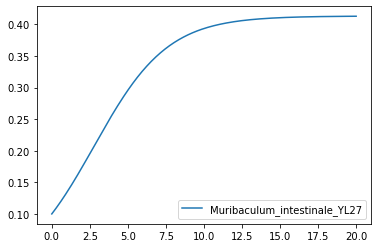

In [18]:
testsim["Microbes"].T.plot()

## Simulating Pairs and Comparing to Growth Experiments.

In [21]:
spc

['Clostridium_innocuum_I46',
 'Bacteroides_caecimuris_I48',
 'Limosilactobacillus_reuteri_I49',
 'Flavonifractor_plautii_YL31',
 'Muribaculum_intestinale_YL27',
 'Akkermansia_muciniphilaYL44',
 'Turicimonas_muris_YL45',
 'Acutalibacter_muris_KB1',
 'Enterocloster_clostridioformis_YL32',
 'Bifidobacterium_animalis_YL2',
 'Enterococcus_faecalis_KB1',
 'Blautia_coccoides_YL58']

In [20]:
import itertools

In [28]:
list(itertools.combinations(spc, 2))

[('Clostridium_innocuum_I46', 'Bacteroides_caecimuris_I48'),
 ('Clostridium_innocuum_I46', 'Limosilactobacillus_reuteri_I49'),
 ('Clostridium_innocuum_I46', 'Flavonifractor_plautii_YL31'),
 ('Clostridium_innocuum_I46', 'Muribaculum_intestinale_YL27'),
 ('Clostridium_innocuum_I46', 'Akkermansia_muciniphilaYL44'),
 ('Clostridium_innocuum_I46', 'Turicimonas_muris_YL45'),
 ('Clostridium_innocuum_I46', 'Acutalibacter_muris_KB1'),
 ('Clostridium_innocuum_I46', 'Enterocloster_clostridioformis_YL32'),
 ('Clostridium_innocuum_I46', 'Bifidobacterium_animalis_YL2'),
 ('Clostridium_innocuum_I46', 'Enterococcus_faecalis_KB1'),
 ('Clostridium_innocuum_I46', 'Blautia_coccoides_YL58'),
 ('Bacteroides_caecimuris_I48', 'Limosilactobacillus_reuteri_I49'),
 ('Bacteroides_caecimuris_I48', 'Flavonifractor_plautii_YL31'),
 ('Bacteroides_caecimuris_I48', 'Muribaculum_intestinale_YL27'),
 ('Bacteroides_caecimuris_I48', 'Akkermansia_muciniphilaYL44'),
 ('Bacteroides_caecimuris_I48', 'Turicimonas_muris_YL45'),
 